In [36]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
import datetime
import tensorflow as tf
from keras import layers
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, load_model
from keras.datasets import cifar10
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import figure

In [37]:
batch_size = 32
epochs = 200
data_augmentation = True
num_classes = 10
subtract_pixel_mean = True
n = 3
version = 1

if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
model_type = 'ResNet % dv % d' % (depth, version)

#Use the CIFAR-10 Dataset, it contains 60,000 color images of varying kinds across 10 classes
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

input_shape = x_train.shape[1:]

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis = 0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [38]:
#We set an incremental learning rate, based on the number of epochs. As epochs grows, the learning rate decreases to avoid overshooting minima.

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning Rate: ', lr)
    return lr



In [39]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x= Activation(activation)(x)
        x = conv(x)
    return x


In [40]:
def resnet_v1(input_shape, depth, num_classses=10):
    if (depth -2) % 6 != 0:
        raise ValueError('depth should be 6n + 2 (eg 20, 32, 44 in [a])')
    
    num_filters = 16
    num_res_blocks = int((depth - 2) /6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)

    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:
                strides = 2
            y = resnet_layer(inputs=x,
                              num_filters=num_filters,
                              strides=strides)
            y= resnet_layer(inputs=y,
                            num_filters=num_filters,
                            activation=None)
            if stack > 0 and res_block == 0:
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x,y])
            x = Activation('relu')(x)
        num_filters *= 2 
    
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [41]:
def resnet_v2(input_shape, depth, num_classes=10):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n + 2 (eg 56 or 110 in [b])')
    
    num_filters_in = 16
    num_res_blocks = int((depth -2) / 9)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)
    
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage ==0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:
                    strides = 2

            y = resnet_layer(inputs=x,
                              num_filters=num_filters_in,
                              kernel_size=1,
                              strides=strides,
                              activation=activation,
                              batch_normalization=batch_normalization,
                              conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                           num_filters=num_filters_out,
                           kernel_size=1,
                           conv_first=False)
            if res_block == 0:
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x ,y])
        num_filters_in = num_filters_out
    
    x= BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model
            
            


In [ ]:
#Train and test ResNet v1 and v2 architectures

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.keras' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir,
                            histogram_freq=1,
                            write_graph=True,
                            write_images=False,
                            write_steps_per_second=False,
                            update_freq="epoch",
                            profile_batch=0,
                            embeddings_freq=0,
                            embeddings_metadata=None,
                        )

callbacks = [checkpoint, lr_reducer, lr_scheduler, tensorboard]

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation')

    data_augmentation_layers = tf.keras.Sequential([
        layers.RandomRotation(20/360),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomFlip("horizontal"),
    ])

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.map(
        lambda x, y: (data_augmentation_layers(x, training=True), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    #Load in a specific model for more training
    model = load_model("C:\\Users\\pokeh\\Documents\\GitHub\\gradient_descent_practice\\saved_models\\cifar10_ResNet  20v  1_model.112.keras")
    initial_epoch = 112
    additional_epochs = 88
    history = model.fit(train_dataset,
              steps_per_epoch=x_train.shape[0] // batch_size,
              epochs=initial_epoch + additional_epochs,
              initial_epoch = initial_epoch,
              validation_data=(x_test, y_test),
              callbacks=callbacks)
    


Learning Rate:  0.001


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 32, 32,    │        448 │ input_layer_8[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_114[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_103      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 32, 32,    │      2,320 │ activation_103[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_115[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_104      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 32, 32,    │      2,320 │ activation_104[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_116[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 32, 32,    │          0 │ activation_103[0… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_105      │ (None, 32, 32,    │          0 │ add_36[0][0]      │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 32, 32,    │      2,320 │ activation_105[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_117[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_106      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 32, 32,    │      2,320 │ activation_106[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_118[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_37 (Add)        │ (None, 32, 32,    │          0 │ activation_105[0

 Total params: 274,442 (1.05 MB)

 Trainable params: 273,066 (1.04 MB)

 Non-trainable params: 1,376 (5.38 KB)

ResNet  20v  1
Using real-time data augmentation


ValueError: File not found: filepath=cifar10_ResNet  20v  1_model.112.keras. Please ensure the file is an accessible `.keras` zip file.

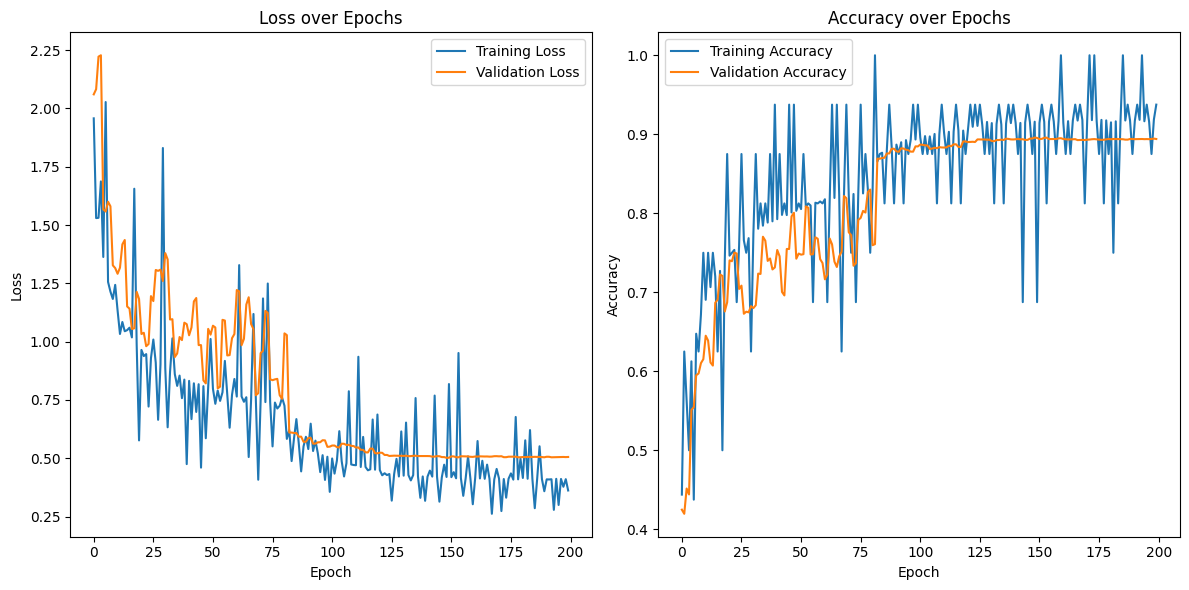

In [ ]:
#Extract Metrics from history, to view training metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(len(loss))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()